## 0. Libarary 불러오기

In [23]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

## 1. 데이터셋 정의

### (1) Train Dataset

In [174]:
# 학습 데이터셋 폴더 경로를 지정해주세요.
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')

In [175]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [304]:
masks = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'incorrect_mask', 'normal']
wears = ['Wear', 'Wear', 'Wear', 'Wear', 'Wear', 'Incorrect', 'Not Wear']
mask_df = pd.DataFrame()
for person in train_df.values:
    for mask, wear in zip(masks, wears):
        mask_df = mask_df.append(pd.Series(np.append(person, (mask, wear))), ignore_index=True)
mask_df.columns = np.append(train_df.columns.values, ('mask', 'wear'))
mask_df

,id,gender,race,age,path,mask,wear
0,000001,female,Asian,45.0,000001_female_Asian_45,mask1,Wear
1,000001,female,Asian,45.0,000001_female_Asian_45,mask2,Wear
2,000001,female,Asian,45.0,000001_female_Asian_45,mask3,Wear
3,000001,female,Asian,45.0,000001_female_Asian_45,mask4,Wear
4,000001,female,Asian,45.0,000001_female_Asian_45,mask5,Wear
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19.0,006959_male_Asian_19,mask3,Wear
18896,006959,male,Asian,19.0,006959_male_Asian_19,mask4,Wear
18897,006959,male,Asian,19.0,006959_male_Asian_19,mask5,Wear
18898,006959,male,Asian,19.0,006959_male_Asian_19,incorrect_mask,Incorrect


In [178]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

In [179]:
class GenderDataset(Dataset):
    def __init__(self, path, mask_df, transform):
        super(GenderDataset).__init__()
        self.path = path
        self.mask_df = mask_df
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.mask_df['path'][idx], self.mask_df['mask'][idx])
        full_path = os.path.join(self.path, img_path)
        image = Image.open(full_path + '.jpg')
        if self.transform:
            image = self.transform(image)
        
        label = self.mask_df['gender'][idx]
        label = 0 if label=='male' else 1
        return image, label
    
    def __len__(self):
        return len(self.mask_df)

In [180]:
gender_dataset = GenderDataset(trainimage_dir, mask_df, transform)

In [181]:
gender_dataset[0][0].shape

torch.Size([3, 512, 384])

In [182]:
gender_loader = DataLoader(
    gender_dataset,
    shuffle=True
)

In [183]:
class AgeDataset(Dataset):
    def __init__(self, path, mask_df, transform):
        self.path = path
        self.mask_df = mask_df
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.mask_df['path'][idx], self.mask_df['mask'][idx])
        full_path = os.path.join(self.path, img_path)
        image = Image.open(full_path + '.jpg')
        if self.transform:
            image = self.transform(image)
        
        label = self.mask_df['age'][idx]
        if label >= 60.0:
            label = 2
        elif label >= 30.0:
            label = 1
        else:
            label = 0
        return image, label
    
    def __len__(self):
        return len(self.mask_df)

In [184]:
age_dataset = AgeDataset(trainimage_dir, mask_df, transform)

In [185]:
age_dataset[0][0].shape

torch.Size([3, 512, 384])

In [186]:
age_loader = DataLoader(
    age_dataset,
    shuffle=True
)

In [187]:
class MaskDataset(Dataset):
    def __init__(self, path, mask_df, transform):
        self.path = path
        self.mask_df = mask_df
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.mask_df['path'][idx], self.mask_df['mask'][idx])
        full_path = os.path.join(self.path, img_path)
        image = Image.open(full_path + '.jpg')
        if self.transform:
            image = self.transform(image)
        
        label = self.mask_df['mask'][idx]
        if label.startswith('mask'):
            label = 0
        elif label.startswith('incorrect'):
            label = 1
        else:
            label = 2
        return image, label
    
    def __len__(self):
        return len(self.mask_df)

In [188]:
mask_dataset = MaskDataset(trainimage_dir, mask_df, transform)

In [189]:
mask_dataset[0][0].shape

torch.Size([3, 512, 384])

In [190]:
mask_loader = DataLoader(
    mask_dataset,
    shuffle=True
)

### (2) Test Dataset

In [191]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [192]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [193]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
testimage_dir = os.path.join(test_dir, 'images')

In [194]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(testimage_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
test_dataset = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

## 2. EDA

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

In [305]:
mask_df

,id,gender,race,age,path,mask,wear
0,000001,female,Asian,45.0,000001_female_Asian_45,mask1,Wear
1,000001,female,Asian,45.0,000001_female_Asian_45,mask2,Wear
2,000001,female,Asian,45.0,000001_female_Asian_45,mask3,Wear
3,000001,female,Asian,45.0,000001_female_Asian_45,mask4,Wear
4,000001,female,Asian,45.0,000001_female_Asian_45,mask5,Wear
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19.0,006959_male_Asian_19,mask3,Wear
18896,006959,male,Asian,19.0,006959_male_Asian_19,mask4,Wear
18897,006959,male,Asian,19.0,006959_male_Asian_19,mask5,Wear
18898,006959,male,Asian,19.0,006959_male_Asian_19,incorrect_mask,Incorrect


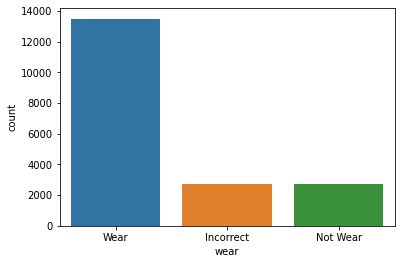

In [308]:
sns.countplot(x='wear', data=mask_df)
plt.show()

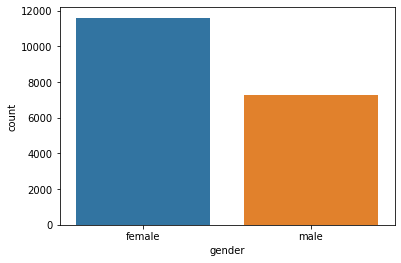

In [309]:
sns.countplot(x='gender', data=mask_df)
plt.show()

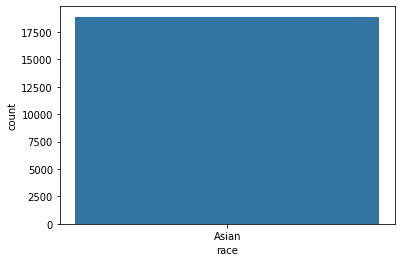

In [199]:
sns.countplot(x='race', data=mask_df)

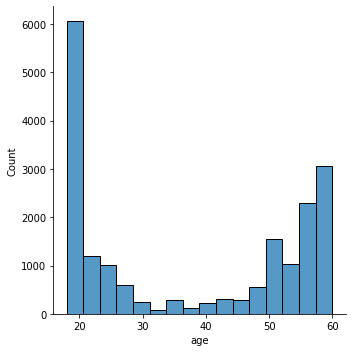

In [201]:
sns.displot(mask_df['age'])

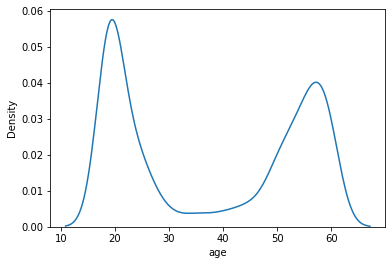

In [209]:
sns.kdeplot(x=mask_df['age'])

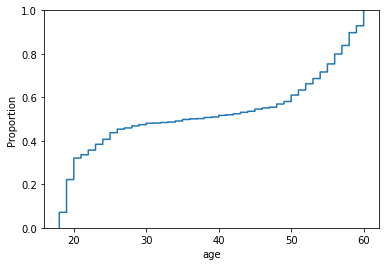

In [210]:
sns.ecdfplot(x=mask_df['age'])

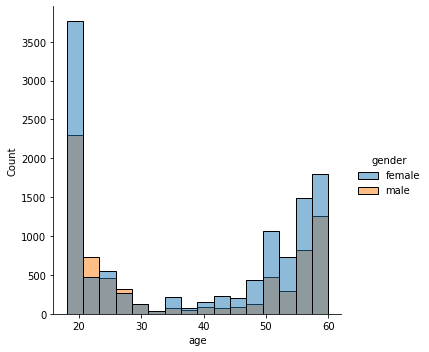

In [311]:
sns.displot(data=mask_df, x='age', hue='gender')
plt.show()

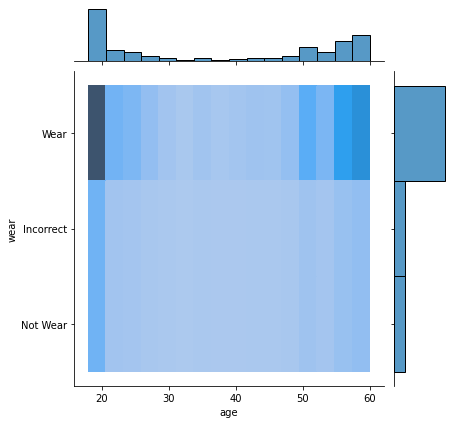

In [326]:
sns.jointplot(data=mask_df, x='age', y='wear', kind='hist')
plt.show()

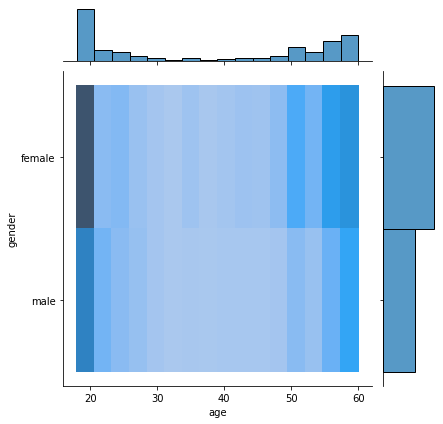

In [327]:
sns.jointplot(data=mask_df, x='age', y='gender', kind='hist')
plt.show()

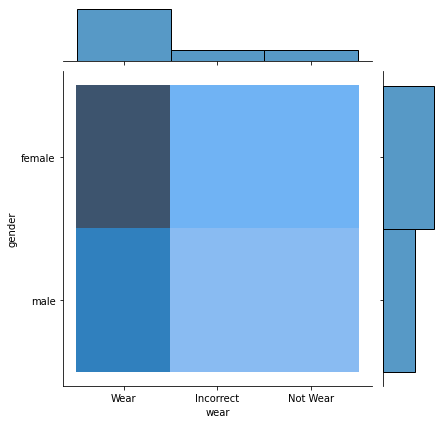

In [328]:
sns.jointplot(data=mask_df, x='wear', y='gender', kind='hist')
plt.show()

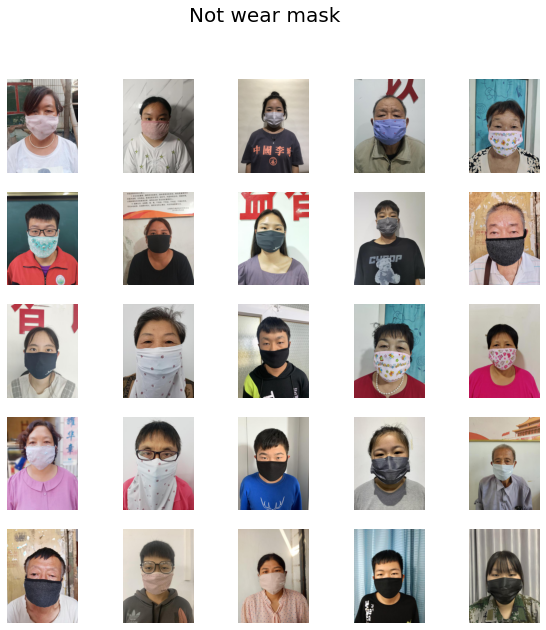

In [313]:
wear_df = mask_df[mask_df['mask']=='mask5']
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = np.random.randint(len(wear_df))
    img_path = os.path.join(wear_df.iloc[idx,4], wear_df.iloc[idx,5])
    full_path = os.path.join(trainimage_dir, img_path)
    #image = cv2.imread(full_path, cv2.COLOR_BGR2RGB)
    try:
        image = Image.open(full_path + '.jpg')
    except:
        try:
            image = Image.open(full_path + '.png')
        except:
            image = Image.open(full_path + '.jpeg')
    plt.imshow(image)
    plt.suptitle("Not wear mask",fontsize=20)
    plt.axis('off')
plt.show()

In [251]:
import glob
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')
person_list = glob.glob(trainimage_dir + '/*')
ext_dict = {}
for person in person_list:
    img_list = glob.glob(person + '/*')
    for img_path in img_list:
        ext = img_path.split('.')[-1]
        if ext in ext_dict.keys():
            ext_dict[ext] += 1
        else:
            ext_dict[ext] = 1
ext_dict

{'jpg': 18035, 'png': 511, 'jpeg': 354}

In [255]:
import glob
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')
person_list = glob.glob(trainimage_dir + '/*')
size_dict = {}
for person in person_list:
    img_list = glob.glob(person + '/*')
    for img_path in img_list:
        size = Image.open(img_path).size # (width, height)
        if size in size_dict.keys():
            size_dict[size] += 1
        else:
            size_dict[size] = 1
size_dict

{(384, 512): 18900}

In [256]:
import glob
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')
person_list = glob.glob(trainimage_dir + '/*')
shape_dict = {}
for person in person_list:
    img_list = glob.glob(person + '/*')
    for img_path in img_list:
        shape = np.array(Image.open(img_path)).shape # (height, width, channel)
        if shape in shape_dict.keys():
            shape_dict[shape] += 1
        else:
            shape_dict[shape] = 1
shape_dict

{(512, 384, 3): 18900}

In [291]:
import glob
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')
person_list = glob.glob(trainimage_dir + '/*')
rgb = np.array([0.0, 0.0, 0.0])
count = 0
for person in person_list:
    img_list = glob.glob(person + '/*')
    for img_path in img_list:
        mean = np.array(Image.open(img_path)).mean(axis=(0,1))
        rgb = rgb + mean
        count += 1
rgb/count

array([142.84936376, 133.64580901, 127.87153421])

In [293]:
rgb/255.0/count

array([0.56019358, 0.52410121, 0.501457  ])

In [292]:
count

18900

In [294]:
import glob
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')
person_list = glob.glob(trainimage_dir + '/*')
rgb = np.array([0.0, 0.0, 0.0])
count = 0
for person in person_list:
    img_list = glob.glob(person + '/*')
    for img_path in img_list:
        std = np.array(Image.open(img_path)).std(axis=(0,1))
        rgb = rgb + std
        count += 1
rgb/count

array([59.4624383 , 61.96508394, 62.64717999])

In [295]:
rgb/255.0/count

array([0.23318603, 0.24300033, 0.24567522])

## 3. Training

## 4. Inference

In [5]:
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = MyModel(num_classes=18).to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
